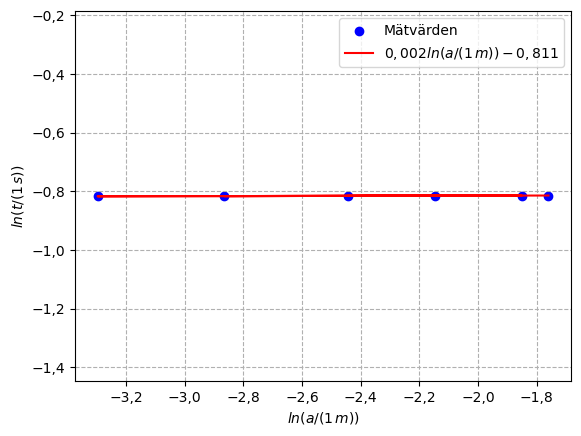

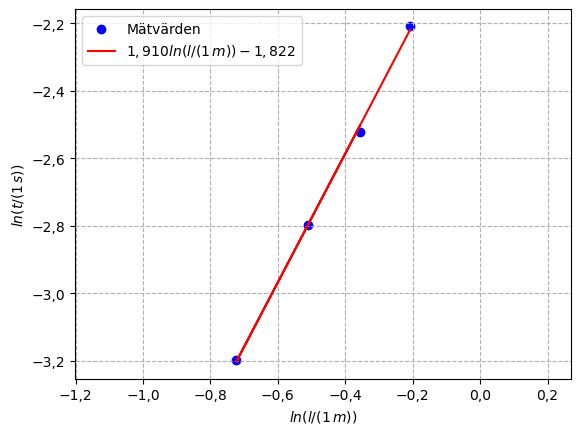

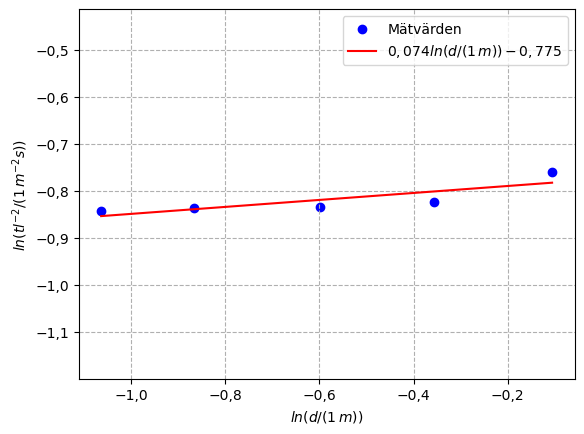

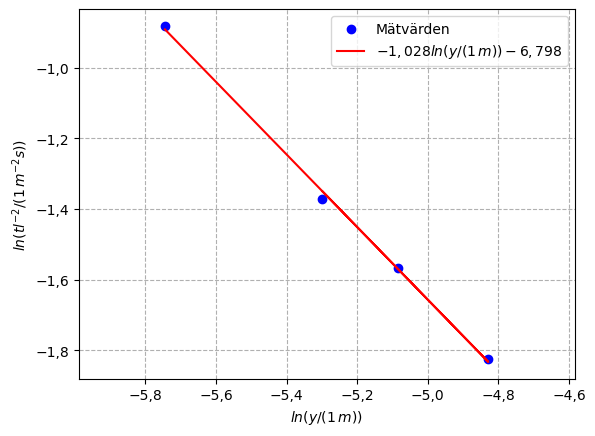

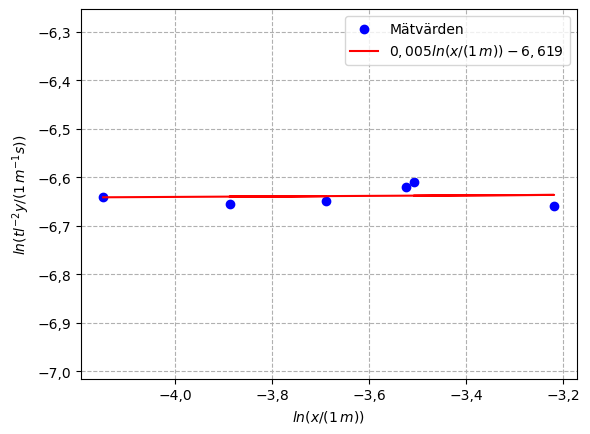

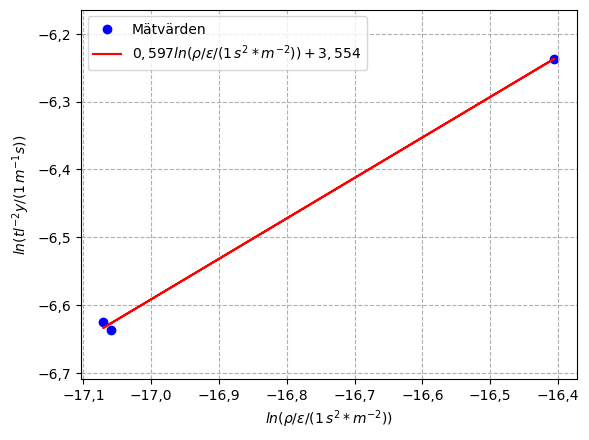

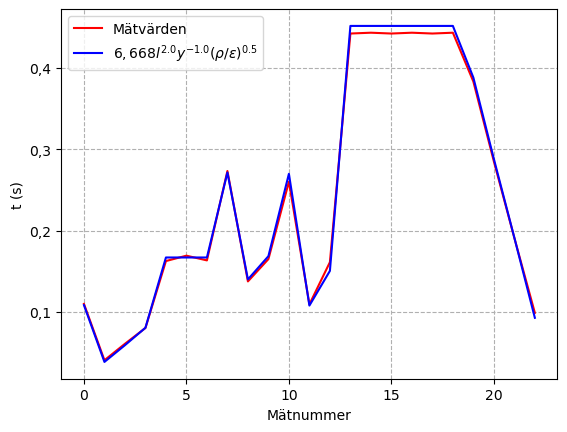

In [1]:
import numpy as np
import locale
# Set to German locale to get comma decimal separater
locale.setlocale(locale.LC_NUMERIC, "de_DE")
import matplotlib.pyplot as plt
plt.rcdefaults()

# Tell matplotlib to use the locale we set above
plt.rcParams['axes.formatter.use_locale'] = True
varden = np.loadtxt('Vibrerande värden.txt', dtype = 'str',delimiter = '\t')
for i in range(len(varden)):
    for j in range(len(varden[i])):
        varden[i][j] = varden[i][j].replace(',','.')
rvariables = ['t','l','x','y','ρ','ε','a','d'] #names for all values
uvariables = ['t','l','x','y',r'ρ/ε','a','d'] #names for combined values (use this if no composite variables are used)
linorder = ['a','l','d','y','x',r'ρ/ε'] #the order of variables to be linearized
runits = {'t':'s','l':'m','x':'m','y':'m','ρ':'kg*m^-3','ε':'kg*s^-2*m^-1','a':'m','d':'m'} #SI-units for all variables
uunits = {'t':'s','l':'m','x':'m','y':'m',r'ρ/ε':'s^2*m^{-2}','a':'m','d':'m'} #SI-units for all variables (use this if no composite variables are used)
unitpows = {'m':0,'s':0,'kg':0}
rcollecteddata = {}
determined = {}
rexp = {}
for variable in rvariables: 
    rcollecteddata[variable] = []
    if rvariables[0] == variable: rexp[variable] = -1
    else: rexp[variable] = 0
ucollecteddata = {}
uexp = {}
for variable in uvariables: 
    ucollecteddata[variable] = []
    if uvariables[0] == variable: 
        uexp[variable] = -1
        determined[variable] = True
    else: 
        uexp[variable] = 0
        determined[variable] = False
C = 0.
def collectdata(dicti,num): #convert measurement data from a txt-file into a dictionary
    for i in range(len(varden)):
        rcollecteddata[dicti].append(float(varden[i][num]))
def compositevariables():
    for unit in uunits:
        divideis = False
        for symbol in unit:
            if symbol == '/':
                divideis = True
                divide = unit.split('/')
                for i in range(len(rcollecteddata[divide[0]])):
                    ucollecteddata[unit].append(rcollecteddata[divide[0]][i]/rcollecteddata[divide[1]][i])
        if not divideis:
            for i in range(len(rcollecteddata[unit])):
                    ucollecteddata[unit].append(rcollecteddata[unit][i])
def choosemeasures(var,det,collecteddata,variables): #choose series of measurement with the objective of creating a broad series with respect to (un)determined variables
    vals = []
    occur= []
    for i in range(len(collecteddata[var])):
        val = {}
        earlierseries = True
        for variable in variables:
            val[variable] = collecteddata[variable][i]
        if len(vals) == 0: earlierseries = False
        else:
            for j in range(len(vals)):
                earlierseries = True
                for variable in variables:
                    if (not determined[variable]) and vals[j][variable] != val[variable]: earlierseries = False
                if earlierseries:
                    newmeas = True
                    for k in range(len(vals)):
                        if val[var] == vals[k][var]: 
                            newmeas = False                   
                    if newmeas: occur[j] += 1
                    break
        if not earlierseries: 
            vals.append(val)
            occur.append(1)
    prevmax = 1
    maxnum = 0
    for i in range(len(occur)):
        if occur[i] > prevmax:
            maxnum = i
            prevmax = occur[i]
    return(vals[maxnum])
                
def linearizeandplot(var,det,collecteddata,variables,exp,units): #linearize the given series of measurements using the logarithmic methodology
    det[var] = True
    vals = choosemeasures(var,det,collecteddata,variables)
    for si in unitpows:
        unitpows[si] = 0
    plottedfunc= {'func':[], var:[]}
    for i in range(len(collecteddata[var])):
        usevar = True
        for variable in variables:
            if not det[variable]: 
                if collecteddata[variable][i] != vals[variable]: usevar = False
        if usevar:
            yval = collecteddata[variables[0]][i]
            for variable in variables:
                if exp[variable] != 0 and variable != variables[0]:
                    yval /= (collecteddata[variable][i]**exp[variable])
            yval = np.log(yval)
            xval = np.log(collecteddata[var][i])
            plottedfunc['func'].append(yval)
            plottedfunc[var].append(xval)
            uplottedfunc = {'func':[], var:[]}
            occur = []
        for i in range(len(plottedfunc[var])):
            useries = True
            if uplottedfunc[var] != 0:
                for j in range(len(uplottedfunc[var])):
                    if plottedfunc[var][i] == uplottedfunc[var][j]:
                        occur[j] += 1.
                        uplottedfunc['func'][j] = (uplottedfunc['func'][j]*(occur[j] -1) + plottedfunc['func'][i])/occur[j]
                        useries = False
                        break
            if useries:
                uplottedfunc['func'].append(plottedfunc['func'][i])
                uplottedfunc[var].append(plottedfunc[var][i])
                occur.append(1.)
    coeffs = np.polyfit(uplottedfunc[var], uplottedfunc['func'], 1)
    ylabel = '$ln('
    for variable in variables:
        if exp[variable] != 0:
            ylabel += variable
            if exp[variable] != -1: ylabel += '^{' + str(int(-exp[variable])) + '}'
            unitpows[units[variable]] += exp[variable]
    fracexist = False
    for si in unitpows:
        if unitpows[si] != 0: 
            if not fracexist:
                ylabel += r'/(1\,'
                fracexist = True
            ylabel += si
            if unitpows[si] != -1: ylabel += '^{' + str(int(-unitpows[si])) + '}'
    if fracexist: ylabel += ')'
    ylabel += ')$'
    size = np.max([np.max(uplottedfunc[var])-np.min(uplottedfunc[var]),np.max(uplottedfunc['func']) - np.min(uplottedfunc['func'])])
    plt.scatter(uplottedfunc[var],uplottedfunc['func'], label = 'Mätvärden', color = 'blue')
    plt.axis('equal')
    yvals = []
    for i in range(len(plottedfunc[var])):
        yvals.append(plottedfunc[var][i]*coeffs[0] + coeffs[1])
    xlabel ='$ln('+var+r'/(1\,'+units[var]+'))$'
    const = f'{coeffs[1]:.3f}'.replace('.',',')
    sign = ''
    if coeffs[1] > 0: sign += '+'
    elif coeffs[1] == 0: const = ''
    funclabel = '$' + f'{coeffs[0]:.3f}'.replace('.',',') + xlabel.strip('$') + sign + const + '$'
    plt.plot(plottedfunc[var], yvals, color = 'red', label = funclabel)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(linestyle = '--')
    plt.legend()
    fig = plt.gcf()
    filename = var.replace('/', '%') + '-linjärisering.png'
    fig.savefig(filename, bbox_inches = 'tight')
    plt.show()
    exp[var] = np.round(coeffs[0]*2)/2.
def compareformula(collecteddata, variables, exp, units): #use the formula to approximate values and compare the to the actual values
    coeffs = []
    formvals = []
    measnum = []
    for i in range(len(collecteddata[variables[0]])):
        formval = 1
        for variable in variables:
            if variable != variables[0]:
                formval *= collecteddata[variable][i]**exp[variable]
        coeffs.append(collecteddata[variables[0]][i]/formval)
        formvals.append(formval)
        measnum.append(i)
    C = np.mean(coeffs)
    for i in range(len(formvals)): formvals[i] *= C
    plt.plot(measnum, collecteddata[variables[0]], color = 'red', label = 'Mätvärden')
    formlabel = '$' + f'{C:.3f}'.replace('.',',')
    for variable in variables:
        parentheses = False
        usevar = ''
        for sign in variable: 
            if sign == '/': parentheses = True
        if parentheses: usevar += '(' + variable + ')'
        else: usevar += variable
        if exp[variable] != 0 and variable != variables[0]: formlabel += usevar + '^{' + f'{exp[variable]:.1f}' + '}'
    formlabel += '$'
    plt.plot(measnum, formvals, color = 'blue', label = formlabel)
    xlabel = 'Mätnummer'
    ylabel = variables[0] + ' (' + units[variables[0]] + ')'
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(linestyle = '--')
    plt.legend()
    fig = plt.gcf()
    fig.savefig('Jämförelse.png', bbox_inches = 'tight')
    plt.show()
for i in range(len(rvariables)):
    collectdata(rvariables[i],i)
compositevariables()
for variable in linorder:linearizeandplot(variable,determined,ucollecteddata,uvariables,uexp,uunits)
compareformula(ucollecteddata, uvariables, uexp, uunits)